In [1]:
from __future__ import division
from collections import defaultdict
import numpy as np
import seaborn as sns
import sys

import warnings
warnings.filterwarnings('ignore')

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

TODO: NCHS categories, gradient win difference for mapping

In [2]:
county_data = r'~/Documents/Python/county_election_analysis/CountyCharacteristics.csv'
    
county_df = pd.read_csv(county_data, header=0, index_col=0)
county_df.drop(['State'], axis=1, inplace=True)
county_df.head()
county_df.shape

,MedianHouseholdIncome,TotalPopulation,Male,Female,Age0_4,Age5_9,Age10_14,Age15_19,Age20_24,Age25_34,Age35_44,Age45_54,Age55_59,Age60_64,Age65_74,Age75_84,Age85,MedianAge,White,Black,AmericanIndianAlaskaNative,Asian,NativeHawaiianPacificIslander,OtherRace,Hispanic,SimpsonDiversityIndex,Population25Plus,EdK8,Ed9_12,EdHS,EdCollNoDegree,EdAssocDegree,EdBachelorDegree,EdGraduateDegree,MedianHousingCosts,Married,Widowed,Divorced,Separated,NeverMarried,Uninsured,ForeignBorn,NonCitizen,Disability,MfgEmp1970,MfgEmp1980,MfgEmp1990,MfgEmp2001,MfgEmp2015,TotalEmp1970,TotalEmp1980,TotalEmp1990,TotalEmp2001,TotalEmp2015,LandAreaSqMiles,Employment,LaborForce,Unemployment,TotalSSI,AgedSSI,BlindDisabledSSI,OASDI,SSIPayments,NCHS_UrbanRural2013,NCHS_UrbanRural2006,NCHS_UrbanRural1990
County,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1001,51281.0,55221,26745,28476,3242,3890,4314,4034,3422,6724,7716,8173,3530,2698,4560,2311,607,37.7,43492,10593,489,777,151,585,1440,0.362641,36319,1394,3262,12182,8203,2841,4897,3540,881,23989,2539,5472,832,10944,5508,861,474,9400,1607.0,2763.0,2343.0,2078.0,1536.0,6853.0,11255.0,11400.0,16215.0,17182.0,594.446365,24762.0,26177.0,1415.0,1497.0,71.0,1426.0,529.0,825000.0,Medium metro,Medium metro,Medium metro
1003,50254.0,195121,95314,99807,10494,12787,12868,11793,10178,22740,24627,27202,13043,14013,21054,10422,3900,42.2,171423,19682,2573,2244,24,2627,8776,0.244462,137001,4385,9975,39431,31080,12420,26388,13322,879,85527,11764,20348,3656,37676,24987,6864,4088,26550,3291.0,4019.0,5571.0,5725.0,4606.0,19749.0,27777.0,40545.0,70659.0,103690.0,1589.808080,85594.0,90591.0,4997.0,3510.0,196.0,3314.0,1295.0,1870000.0,Small metro,Micropolitan (nonmetropolitan),Medium metro
1005,32964.0,26932,14497,12435,1476,1752,1570,1493,1833,3870,3360,3783,1848,1622,2616,1291,418,38.8,13055,12809,264,293,0,933,1241,0.551576,18808,1732,3289,6490,3593,1350,1412,942,556,9186,1793,3077,708,7371,3732,683,454,5526,2044.0,2465.0,3679.0,4809.0,2253.0,9448.0,9724.0,12099.0,15239.0,12074.0,884.876140,7839.0,8572.0,733.0,1507.0,110.0,1397.0,606.0,787000.0,Noncore (nonmetropolitan),Micropolitan (nonmetropolitan),"With a city of 10,000 or more (nonmetropolitan)"
1007,38678.0,22604,12073,10531,1133,1458,1420,1603,1361,3086,3445,3131,1351,1361,1986,997,272,38.9,17612,5098,162,35,0,7,502,0.359682,15629,1086,1938,6574,3413,954,946,718,617,9111,1506,2287,502,5187,2007,220,167,3008,1696.0,1564.0,1703.0,599.0,394.0,3965.0,4262.0,5531.0,5736.0,6383.0,622.582611,8161.0,8747.0,586.0,1002.0,34.0,968.0,423.0,509000.0,Large fringe metro,Large fringe metro,"Without a city of 10,00 or more (nonmetropolitan)"
1009,45813.0,57710,28512,29198,3545,3773,3921,3923,3140,6768,7445,8246,3740,3697,5804,2869,839,40.7,55836,1231,810,231,26,577,4980,0.094797,39408,2745,5727,13179,8827,3850,3396,1684,641,27418,3718,5298,790,9248,6659,2393,1802,9291,1563.0,1840.0,2532.0,2549.0,1329.0,7587.0,9467.0,11751.0,14971.0,14519.0,644.806774,23871.0,25262.0,1391.0,1333.0,65.0,1268.0,517.0,687000.0,Large fringe metro,Large fringe metro,Medium metro


(3141, 66)

In [3]:
voting_data_16 = r'~/Documents/Python/county_election_analysis/PresidentialElectionResults2016.csv'
voting_data_12 = r'~/Documents/Python/county_election_analysis/PresidentialElectionResults2012.csv'
voting_data_08 = r'~/Documents/Python/county_election_analysis/PresidentialElectionResults2008.csv'
voting_data_04 = r'~/Documents/Python/county_election_analysis/PresidentialElectionResults2004.csv'
voting_data_00 = r'~/Documents/Python/county_election_analysis/PresidentialElectionResults2000.csv'

results = [pd.read_csv(voting_data_16, header=0, index_col=0),
           pd.read_csv(voting_data_12, header=0, index_col=0),
           pd.read_csv(voting_data_08, header=0, index_col=0),
           pd.read_csv(voting_data_04, header=0, index_col=0),
           pd.read_csv(voting_data_00, header=0, index_col=0)]

# get the translation table
state_id = results[0][['StateName', 'StateAbbr', 'CountyName']]

for result in results:
    result.drop(
        ['dPct', 'rPct', 'otherPct', 'leanD', 'leanR', 'dDRPct', 'rDRPct',
        'StateName', 'StateAbbr', 'CountyName'], axis=1, inplace=True)

for yr, result in zip(['16', '12', '08', '04', '00'], results):
    result.columns = [yr + '_' + c for c in result.columns]
    
voting_df, d2, d3, d4, d5 = results
voting_df = voting_df.join(d2.join(d3.join(d4.join(d5))))
voting_df.head()
voting_df.shape

,16_clinton,16_trump,16_johnson,16_stein,16_other,16_totalvotes,12_obama,12_romney,12_johnson,12_stein,12_other,12_totalvotes,08_mccain,08_obama,08_other,08_totalvotes,04_bush,04_kerry,04_other,04_totalvotes,00_bush,00_gore,00_nader,00_browne,00_other,00_totalvotes
County,,,,,,,,,,,,,,,,,,,,,,,,,,
1001,5936,18172,546,105.0,214.0,24973,6363.0,17379.0,137.0,22.0,36.0,23937.0,17403.0,6093.0,145.0,23641.0,15196.0,4758.0,127.0,20081.0,11993.0,4942.0,160.0,51.0,5.0,17146.0
1003,18458,72883,2464,456.0,954.0,95215,18424.0,66016.0,607.0,169.0,137.5,85353.5,61271.0,19386.0,756.0,81413.0,52971.0,15599.0,750.0,69320.0,40872.0,13997.0,1033.0,226.0,5.0,56128.0
1005,4871,5454,93,18.0,33.0,10469,5912.0,5550.0,32.0,6.0,8.5,11508.5,5866.0,5697.0,67.0,11630.0,5899.0,4832.0,46.0,10777.0,5096.0,5188.0,46.0,27.0,5.0,10357.0
1007,1874,6738,124,17.0,66.0,8819,2202.0,6132.0,38.0,9.0,19.5,8400.5,6262.0,2299.0,83.0,8644.0,5472.0,2089.0,39.0,7600.0,4273.0,2710.0,52.0,20.0,5.0,7055.0
1009,2156,22859,338,89.0,146.0,25588,2970.0,20757.0,170.0,50.0,56.5,24003.5,20389.0,3522.0,356.0,24267.0,17386.0,3938.0,180.0,21504.0,12667.0,4977.0,154.0,51.0,5.0,17849.0


(3144, 26)

In [4]:
primary_data_16 = r'~/Documents/Python/county_election_analysis/primary_results.csv'
primaries_df = pd.read_csv(primary_data_16, header=0, index_col=3)

prmry_hillary = primaries_df[primaries_df.candidate == 'Hillary Clinton'].copy()
prmry_dumpstr = primaries_df[primaries_df.candidate == 'Donald Trump'].copy()
prmry_sanders = primaries_df[primaries_df.candidate == 'Bernie Sanders'].copy()

drop_cols = ['candidate', 'state', 'state_abbreviation', 'county', 'party']
prmry_hillary.drop(drop_cols, axis=1, inplace=True)
prmry_dumpstr.drop(drop_cols, axis=1, inplace=True)
prmry_sanders.drop(drop_cols, axis=1, inplace=True)

prmry_hillary.columns = ['clinton_prmry_ct', 'clinton_prmry_prop']
prmry_dumpstr.columns = ['trump_prmry_ct', 'trump_prmry_prop']
prmry_sanders.columns = ['sanders_prmry_ct', 'sanders_prmry_prop']

primary_df = prmry_hillary.join(prmry_sanders.join(prmry_dumpstr))

primary_df.head()
primary_df.shape

,clinton_prmry_ct,clinton_prmry_prop,sanders_prmry_ct,sanders_prmry_prop,trump_prmry_ct,trump_prmry_prop
fips,,,,,,
1001.0,2387,0.800,544,0.182,5387.0,0.445
1003.0,5290,0.647,2694,0.329,23618.0,0.469
1005.0,2567,0.906,222,0.078,1710.0,0.501
1007.0,942,0.755,246,0.197,1959.0,0.494
1009.0,564,0.551,395,0.386,7390.0,0.487


(5195, 6)

In [5]:
election_data = voting_df.join(county_df.join(state_id.join(primary_df)))
election_data.head()
election_data.shape

,16_clinton,16_trump,16_johnson,16_stein,16_other,16_totalvotes,12_obama,12_romney,12_johnson,12_stein,12_other,12_totalvotes,08_mccain,08_obama,08_other,08_totalvotes,04_bush,04_kerry,04_other,04_totalvotes,00_bush,00_gore,00_nader,00_browne,00_other,00_totalvotes,MedianHouseholdIncome,TotalPopulation,Male,Female,Age0_4,Age5_9,Age10_14,Age15_19,Age20_24,Age25_34,Age35_44,Age45_54,Age55_59,Age60_64,Age65_74,Age75_84,Age85,MedianAge,White,Black,AmericanIndianAlaskaNative,Asian,NativeHawaiianPacificIslander,OtherRace,Hispanic,SimpsonDiversityIndex,Population25Plus,EdK8,Ed9_12,EdHS,EdCollNoDegree,EdAssocDegree,EdBachelorDegree,EdGraduateDegree,MedianHousingCosts,Married,Widowed,Divorced,Separated,NeverMarried,Uninsured,ForeignBorn,NonCitizen,Disability,MfgEmp1970,MfgEmp1980,MfgEmp1990,MfgEmp2001,MfgEmp2015,TotalEmp1970,TotalEmp1980,TotalEmp1990,TotalEmp2001,TotalEmp2015,LandAreaSqMiles,Employment,LaborForce,Unemployment,TotalSSI,AgedSSI,BlindDisabledSSI,OASDI,SSIPayments,NCHS_UrbanRural2013,NCHS_UrbanRural2006,NCHS_UrbanRural1990,StateName,StateAbbr,CountyName,clinton_prmry_ct,clinton_prmry_prop,sanders_prmry_ct,sanders_prmry_prop,trump_prmry_ct,trump_prmry_prop
County,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1001,5936,18172,546,105.0,214.0,24973,6363.0,17379.0,137.0,22.0,36.0,23937.0,17403.0,6093.0,145.0,23641.0,15196.0,4758.0,127.0,20081.0,11993.0,4942.0,160.0,51.0,5.0,17146.0,51281.0,55221,26745,28476,3242,3890,4314,4034,3422,6724,7716,8173,3530,2698,4560,2311,607,37.7,43492,10593,489,777,151,585,1440,0.362641,36319,1394,3262,12182,8203,2841,4897,3540,881,23989,2539,5472,832,10944,5508,861,474,9400,1607.0,2763.0,2343.0,2078.0,1536.0,6853.0,11255.0,11400.0,16215.0,17182.0,594.446365,24762.0,26177.0,1415.0,1497.0,71.0,1426.0,529.0,825000.0,Medium metro,Medium metro,Medium metro,Alabama,AL,Autauga,2387.0,0.800,544.0,0.182,5387.0,0.445
1003,18458,72883,2464,456.0,954.0,95215,18424.0,66016.0,607.0,169.0,137.5,85353.5,61271.0,19386.0,756.0,81413.0,52971.0,15599.0,750.0,69320.0,40872.0,13997.0,1033.0,226.0,5.0,56128.0,50254.0,195121,95314,99807,10494,12787,12868,11793,10178,22740,24627,27202,13043,14013,21054,10422,3900,42.2,171423,19682,2573,2244,24,2627,8776,0.244462,137001,4385,9975,39431,31080,12420,26388,13322,879,85527,11764,20348,3656,37676,24987,6864,4088,26550,3291.0,4019.0,5571.0,5725.0,4606.0,19749.0,27777.0,40545.0,70659.0,103690.0,1589.808080,85594.0,90591.0,4997.0,3510.0,196.0,3314.0,1295.0,1870000.0,Small metro,Micropolitan (nonmetropolitan),Medium metro,Alabama,AL,Baldwin,5290.0,0.647,2694.0,0.329,23618.0,0.469
1005,4871,5454,93,18.0,33.0,10469,5912.0,5550.0,32.0,6.0,8.5,11508.5,5866.0,5697.0,67.0,11630.0,5899.0,4832.0,46.0,10777.0,5096.0,5188.0,46.0,27.0,5.0,10357.0,32964.0,26932,14497,12435,1476,1752,1570,1493,1833,3870,3360,3783,1848,1622,2616,1291,418,38.8,13055,12809,264,293,0,933,1241,0.551576,18808,1732,3289,6490,3593,1350,1412,942,556,9186,1793,3077,708,7371,3732,683,454,5526,2044.0,2465.0,3679.0,4809.0,2253.0,9448.0,9724.0,12099.0,15239.0,12074.0,884.876140,7839.0,8572.0,733.0,1507.0,110.0,1397.0,606.0,787000.0,Noncore (nonmetropolitan),Micropolitan (nonmetropolitan),"With a city of 10,000 or more (nonmetropolitan)",Alabama,AL,Barbour,2567.0,0.906,222.0,0.078,1710.0,0.501
1007,1874,6738,124,17.0,66.0,8819,2202.0,6132.0,38.0,9.0,19.5,8400.5,6262.0,2299.0,83.0,8644.0,5472.0,2089.0,39.0,7600.0,4273.0,2710.0,52.0,20.0,5.0,7055.0,38678.0,22604,12073,10531,1133,1458,1420,1603,1361,3086,3445,3131,1351,1361,1986,997,272,38.9,17612,5098,162,35,0,7,502,0.359682,15629,1086,1938,6574,3413,954,946,718,617,9111,1506,2287,502,5187,2007,220,167,3008,1696.0,1564.0,1703.0,599.0,394.0,3965.0,4262.0,5531.0,5736.0,6383.0,622.582611,8161.0,8747.0,586.0,1002.0,34.0,968.0,423.0,509000.0,Large fringe metro,Large fringe metro,"Without a city of 10,00 or more (nonmetropolitan)",Alabama,AL,Bibb,942.0,0.755,246.0,0.197,1959.0,0.494
1009,2156,22859,338,89.0,146.0,25588,2970.0,207

(3144, 101)

In [6]:
elections = {
    '16': {'dem': 'clinton', 'rep': 'trump'},
    '12': {'dem': 'obama',   'rep': 'romney'},
    '08': {'dem': 'obama',   'rep': 'mccain'},
    '04': {'dem': 'kerry',   'rep': 'bush'},
    '00': {'dem': 'gore',    'rep': 'bush'}}

for year, election in elections.items():
    dem = election['dem']; rep = election['rep']
    election_data[year + '_president'] = np.where(
    election_data[year + '_' + dem] > election_data[year + '_' + rep], dem, rep)

candidates_by_year = {
y : [c for c in election_data.columns if str(c).startswith(y) and 
    not str(c) in ('{}_president'.format(y), '{}_totalvotes'.format(y))] 
    for y in ['16', '12', '08', '04', '00']}

election_data.head()

candidates_by_year
for year, candidates in candidates_by_year.items():
    for candidate in candidates:
        election_data[candidate] = \
        election_data[candidate] / election_data['{}_totalvotes'.format(year)]

election_data.head()
election_data.shape

,16_clinton,16_trump,16_johnson,16_stein,16_other,16_totalvotes,12_obama,12_romney,12_johnson,12_stein,12_other,12_totalvotes,08_mccain,08_obama,08_other,08_totalvotes,04_bush,04_kerry,04_other,04_totalvotes,00_bush,00_gore,00_nader,00_browne,00_other,00_totalvotes,MedianHouseholdIncome,TotalPopulation,Male,Female,Age0_4,Age5_9,Age10_14,Age15_19,Age20_24,Age25_34,Age35_44,Age45_54,Age55_59,Age60_64,Age65_74,Age75_84,Age85,MedianAge,White,Black,AmericanIndianAlaskaNative,Asian,NativeHawaiianPacificIslander,OtherRace,Hispanic,SimpsonDiversityIndex,Population25Plus,EdK8,Ed9_12,EdHS,EdCollNoDegree,EdAssocDegree,EdBachelorDegree,EdGraduateDegree,MedianHousingCosts,Married,Widowed,Divorced,Separated,NeverMarried,Uninsured,ForeignBorn,NonCitizen,Disability,MfgEmp1970,MfgEmp1980,MfgEmp1990,MfgEmp2001,MfgEmp2015,TotalEmp1970,TotalEmp1980,TotalEmp1990,TotalEmp2001,TotalEmp2015,LandAreaSqMiles,Employment,LaborForce,Unemployment,TotalSSI,AgedSSI,BlindDisabledSSI,OASDI,SSIPayments,NCHS_UrbanRural2013,NCHS_UrbanRural2006,NCHS_UrbanRural1990,StateName,StateAbbr,CountyName,clinton_prmry_ct,clinton_prmry_prop,sanders_prmry_ct,sanders_prmry_prop,trump_prmry_ct,trump_prmry_prop,08_president,12_president,00_president,04_president,16_president
County,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1001,5936,18172,546,105.0,214.0,24973,6363.0,17379.0,137.0,22.0,36.0,23937.0,17403.0,6093.0,145.0,23641.0,15196.0,4758.0,127.0,20081.0,11993.0,4942.0,160.0,51.0,5.0,17146.0,51281.0,55221,26745,28476,3242,3890,4314,4034,3422,6724,7716,8173,3530,2698,4560,2311,607,37.7,43492,10593,489,777,151,585,1440,0.362641,36319,1394,3262,12182,8203,2841,4897,3540,881,23989,2539,5472,832,10944,5508,861,474,9400,1607.0,2763.0,2343.0,2078.0,1536.0,6853.0,11255.0,11400.0,16215.0,17182.0,594.446365,24762.0,26177.0,1415.0,1497.0,71.0,1426.0,529.0,825000.0,Medium metro,Medium metro,Medium metro,Alabama,AL,Autauga,2387.0,0.800,544.0,0.182,5387.0,0.445,mccain,romney,bush,bush,trump
1003,18458,72883,2464,456.0,954.0,95215,18424.0,66016.0,607.0,169.0,137.5,85353.5,61271.0,19386.0,756.0,81413.0,52971.0,15599.0,750.0,69320.0,40872.0,13997.0,1033.0,226.0,5.0,56128.0,50254.0,195121,95314,99807,10494,12787,12868,11793,10178,22740,24627,27202,13043,14013,21054,10422,3900,42.2,171423,19682,2573,2244,24,2627,8776,0.244462,137001,4385,9975,39431,31080,12420,26388,13322,879,85527,11764,20348,3656,37676,24987,6864,4088,26550,3291.0,4019.0,5571.0,5725.0,4606.0,19749.0,27777.0,40545.0,70659.0,103690.0,1589.808080,85594.0,90591.0,4997.0,3510.0,196.0,3314.0,1295.0,1870000.0,Small metro,Micropolitan (nonmetropolitan),Medium metro,Alabama,AL,Baldwin,5290.0,0.647,2694.0,0.329,23618.0,0.469,mccain,romney,bush,bush,trump
1005,4871,5454,93,18.0,33.0,10469,5912.0,5550.0,32.0,6.0,8.5,11508.5,5866.0,5697.0,67.0,11630.0,5899.0,4832.0,46.0,10777.0,5096.0,5188.0,46.0,27.0,5.0,10357.0,32964.0,26932,14497,12435,1476,1752,1570,1493,1833,3870,3360,3783,1848,1622,2616,1291,418,38.8,13055,12809,264,293,0,933,1241,0.551576,18808,1732,3289,6490,3593,1350,1412,942,556,9186,1793,3077,708,7371,3732,683,454,5526,2044.0,2465.0,3679.0,4809.0,2253.0,9448.0,9724.0,12099.0,15239.0,12074.0,884.876140,7839.0,8572.0,733.0,1507.0,110.0,1397.0,606.0,787000.0,Noncore (nonmetropolitan),Micropolitan (nonmetropolitan),"With a city of 10,000 or more (nonmetropolitan)",Alabama,AL,Barbour,2567.0,0.906,222.0,0.078,1710.0,0.501,mccain,obama,gore,bush,trump
1007,1874,6738,124,17.0,66.0,8819,2202.0,6132.0,38.0,9.0,19.5,8400.5,6262.0,2299.0,83.0,8644.0,5472.0,2089.0,39.0,7600.0,4273.0,2710.0,52.0,20.0,5.0,7055.0,38678.0,22604,12073,10531,1133,1458,1420,1603,1361,3086,3445,3131,1351,1361,1986,997,272,38.9,17612,5098,162,35,0,7,502,0.359682,15629,1086,1938,6574,3413,954,946,718,617,9111,1506,2287,502,5187,2007,220,167,3008,1696.0,1564.0,1703.0,599.0,394.0,3965.0,4262.0,5531.0,5736.0,6383.0,622.582611,8161.0,8747.0,586.0,1002.0,34.0,968.0,423.0,509000.0,Large fringe metro,Large fringe

{'00': ['00_bush', '00_gore', '00_nader', '00_browne', '00_other'],
 '04': ['04_bush', '04_kerry', '04_other'],
 '08': ['08_mccain', '08_obama', '08_other'],
 '12': ['12_obama', '12_romney', '12_johnson', '12_stein', '12_other'],
 '16': ['16_clinton', '16_trump', '16_johnson', '16_stein', '16_other']}

,16_clinton,16_trump,16_johnson,16_stein,16_other,16_totalvotes,12_obama,12_romney,12_johnson,12_stein,12_other,12_totalvotes,08_mccain,08_obama,08_other,08_totalvotes,04_bush,04_kerry,04_other,04_totalvotes,00_bush,00_gore,00_nader,00_browne,00_other,00_totalvotes,MedianHouseholdIncome,TotalPopulation,Male,Female,Age0_4,Age5_9,Age10_14,Age15_19,Age20_24,Age25_34,Age35_44,Age45_54,Age55_59,Age60_64,Age65_74,Age75_84,Age85,MedianAge,White,Black,AmericanIndianAlaskaNative,Asian,NativeHawaiianPacificIslander,OtherRace,Hispanic,SimpsonDiversityIndex,Population25Plus,EdK8,Ed9_12,EdHS,EdCollNoDegree,EdAssocDegree,EdBachelorDegree,EdGraduateDegree,MedianHousingCosts,Married,Widowed,Divorced,Separated,NeverMarried,Uninsured,ForeignBorn,NonCitizen,Disability,MfgEmp1970,MfgEmp1980,MfgEmp1990,MfgEmp2001,MfgEmp2015,TotalEmp1970,TotalEmp1980,TotalEmp1990,TotalEmp2001,TotalEmp2015,LandAreaSqMiles,Employment,LaborForce,Unemployment,TotalSSI,AgedSSI,BlindDisabledSSI,OASDI,SSIPayments,NCHS_UrbanRural2013,NCHS_UrbanRural2006,NCHS_UrbanRural1990,StateName,StateAbbr,CountyName,clinton_prmry_ct,clinton_prmry_prop,sanders_prmry_ct,sanders_prmry_prop,trump_prmry_ct,trump_prmry_prop,08_president,12_president,00_president,04_president,16_president
County,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1001,0.237697,0.727666,0.021864,0.004205,0.008569,24973,0.265823,0.726031,0.005723,0.000919,0.001504,23937.0,0.736136,0.257730,0.006133,23641.0,0.756735,0.236940,0.006324,20081.0,0.699463,0.288230,0.009332,0.002974,0.000292,17146.0,51281.0,55221,26745,28476,3242,3890,4314,4034,3422,6724,7716,8173,3530,2698,4560,2311,607,37.7,43492,10593,489,777,151,585,1440,0.362641,36319,1394,3262,12182,8203,2841,4897,3540,881,23989,2539,5472,832,10944,5508,861,474,9400,1607.0,2763.0,2343.0,2078.0,1536.0,6853.0,11255.0,11400.0,16215.0,17182.0,594.446365,24762.0,26177.0,1415.0,1497.0,71.0,1426.0,529.0,825000.0,Medium metro,Medium metro,Medium metro,Alabama,AL,Autauga,2387.0,0.800,544.0,0.182,5387.0,0.445,mccain,romney,bush,bush,trump
1003,0.193856,0.765457,0.025878,0.004789,0.010019,95215,0.215855,0.773442,0.007112,0.001980,0.001611,85353.5,0.752595,0.238119,0.009286,81413.0,0.764152,0.225029,0.010819,69320.0,0.728193,0.249376,0.018404,0.004027,0.000089,56128.0,50254.0,195121,95314,99807,10494,12787,12868,11793,10178,22740,24627,27202,13043,14013,21054,10422,3900,42.2,171423,19682,2573,2244,24,2627,8776,0.244462,137001,4385,9975,39431,31080,12420,26388,13322,879,85527,11764,20348,3656,37676,24987,6864,4088,26550,3291.0,4019.0,5571.0,5725.0,4606.0,19749.0,27777.0,40545.0,70659.0,103690.0,1589.808080,85594.0,90591.0,4997.0,3510.0,196.0,3314.0,1295.0,1870000.0,Small metro,Micropolitan (nonmetropolitan),Medium metro,Alabama,AL,Baldwin,5290.0,0.647,2694.0,0.329,23618.0,0.469,mccain,romney,bush,bush,trump
1005,0.465278,0.520967,0.008883,0.001719,0.003152,10469,0.513707,0.482252,0.002781,0.000521,0.000739,11508.5,0.504385,0.489854,0.005761,11630.0,0.547369,0.448362,0.004268,10777.0,0.492034,0.500917,0.004441,0.002607,0.000483,10357.0,32964.0,26932,14497,12435,1476,1752,1570,1493,1833,3870,3360,3783,1848,1622,2616,1291,418,38.8,13055,12809,264,293,0,933,1241,0.551576,18808,1732,3289,6490,3593,1350,1412,942,556,9186,1793,3077,708,7371,3732,683,454,5526,2044.0,2465.0,3679.0,4809.0,2253.0,9448.0,9724.0,12099.0,15239.0,12074.0,884.876140,7839.0,8572.0,733.0,1507.0,110.0,1397.0,606.0,787000.0,Noncore (nonmetropolitan),Micropolitan (nonmetropolitan),"With a city of 10,000 or more (nonmetropolitan)",Alabama,AL,Barbour,2567.0,0.906,222.0,0.078,1710.0,0.501,mccain,obama,gore,bush,trump
1007,0.212496,0.764032,0.014061,0.001928,0.007484,8819,0.262127,0.729957,0.004524,0.001071,0.002321,8400.5,0.724433,0.265965,0.009602,8644.0,0.720000,0.274868,0.005132,7600.0,0.605670,0.384125,0.007371,0.002835,0.000709,7055.0,38678.0,22604,12073,10531,1133,1458,1420,1603,1361,3086,3445,3131,1351,1361,1986,997,272,38.9,17612,5098,162,35,0,7,502,0.35

(3144, 106)

In [7]:
population_proportions = [
'Male', 'Female', 'Age0_4', 'Age5_9', 'Age10_14', 'Age15_19', 'Age20_24',
'Age25_34', 'Age35_44', 'Age45_54', 'Age55_59', 'Age60_64', 'Age65_74',
'Age75_84', 'Age85', 'White', 'Black', 'AmericanIndianAlaskaNative', 'Asian', 
'NativeHawaiianPacificIslander', 'OtherRace', 'Hispanic',
'Population25Plus', 'EdK8', 'Ed9_12', 'EdHS', 'EdCollNoDegree',
'EdAssocDegree', 'EdBachelorDegree', 'EdGraduateDegree', 
'Married', 'Widowed', 'Divorced', 'Separated', 'NeverMarried', 
'Uninsured', 'ForeignBorn', 'NonCitizen', 'Disability']
for col in population_proportions:
    election_data[col] = election_data[col] / election_data.TotalPopulation

labor_force_proportions = [
'Employment', 'Unemployment', 'TotalSSI',
'AgedSSI', 'BlindDisabledSSI', 'OASDI']
for col in labor_force_proportions:
    election_data[col] = election_data[col] / election_data.LaborForce

# prop manufacturing
mfg = ['MfgEmp1970', 'MfgEmp1980', 'MfgEmp1990', 'MfgEmp2001', 'MfgEmp2015']
emp = \
['TotalEmp1970','TotalEmp1980','TotalEmp1990','TotalEmp2001','TotalEmp2015']
for mfg_, emp_ in zip(mfg, emp):
    c = 'MfgProp'+mfg_[-4:]
    election_data[c] = election_data[mfg_] / election_data[emp_]
    
election_data['mfg_prop_change_1970_2015'] = \
    election_data.MfgProp2015 - election_data.MfgProp1970
election_data['emp_change_1970_2015'] = \
election_data.TotalEmp2015 - election_data.TotalEmp1970

election_data['pop_density_mi2'] = \
    election_data.TotalPopulation / election_data.LandAreaSqMiles
    
election_data['income_median_disposable'] = \
    election_data.MedianHouseholdIncome - \
    election_data.MedianHousingCosts * 12

election_data['SSI_per_capita'] = \
    election_data.SSIPayments / election_data.TotalPopulation
    
election_data.head()
election_data.shape

,16_clinton,16_trump,16_johnson,16_stein,16_other,16_totalvotes,12_obama,12_romney,12_johnson,12_stein,12_other,12_totalvotes,08_mccain,08_obama,08_other,08_totalvotes,04_bush,04_kerry,04_other,04_totalvotes,00_bush,00_gore,00_nader,00_browne,00_other,00_totalvotes,MedianHouseholdIncome,TotalPopulation,Male,Female,Age0_4,Age5_9,Age10_14,Age15_19,Age20_24,Age25_34,Age35_44,Age45_54,Age55_59,Age60_64,Age65_74,Age75_84,Age85,MedianAge,White,Black,AmericanIndianAlaskaNative,Asian,NativeHawaiianPacificIslander,OtherRace,Hispanic,SimpsonDiversityIndex,Population25Plus,EdK8,Ed9_12,EdHS,EdCollNoDegree,EdAssocDegree,EdBachelorDegree,EdGraduateDegree,MedianHousingCosts,Married,Widowed,Divorced,Separated,NeverMarried,Uninsured,ForeignBorn,NonCitizen,Disability,MfgEmp1970,MfgEmp1980,MfgEmp1990,MfgEmp2001,MfgEmp2015,TotalEmp1970,TotalEmp1980,TotalEmp1990,TotalEmp2001,TotalEmp2015,LandAreaSqMiles,Employment,LaborForce,Unemployment,TotalSSI,AgedSSI,BlindDisabledSSI,OASDI,SSIPayments,NCHS_UrbanRural2013,NCHS_UrbanRural2006,NCHS_UrbanRural1990,StateName,StateAbbr,CountyName,clinton_prmry_ct,clinton_prmry_prop,sanders_prmry_ct,sanders_prmry_prop,trump_prmry_ct,trump_prmry_prop,08_president,12_president,00_president,04_president,16_president,MfgProp1970,MfgProp1980,MfgProp1990,MfgProp2001,MfgProp2015,mfg_prop_change_1970_2015,emp_change_1970_2015,pop_density_mi2,income_median_disposable,SSI_per_capita
County,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1001,0.237697,0.727666,0.021864,0.004205,0.008569,24973,0.265823,0.726031,0.005723,0.000919,0.001504,23937.0,0.736136,0.257730,0.006133,23641.0,0.756735,0.236940,0.006324,20081.0,0.699463,0.288230,0.009332,0.002974,0.000292,17146.0,51281.0,55221,0.484327,0.515673,0.058710,0.070444,0.078122,0.073052,0.061969,0.121765,0.139729,0.148005,0.063925,0.048858,0.082577,0.041850,0.010992,37.7,0.787599,0.191829,0.008855,0.014071,0.002734,0.010594,0.026077,0.362641,0.657703,0.025244,0.059072,0.220604,0.148549,0.051448,0.088680,0.064106,881,0.434418,0.045979,0.099093,0.015067,0.198185,0.099745,0.015592,0.008584,0.170225,1607.0,2763.0,2343.0,2078.0,1536.0,6853.0,11255.0,11400.0,16215.0,17182.0,594.446365,0.945945,26177.0,0.054055,0.057188,0.002712,0.054475,0.020209,825000.0,Medium metro,Medium metro,Medium metro,Alabama,AL,Autauga,2387.0,0.800,544.0,0.182,5387.0,0.445,mccain,romney,bush,bush,trump,0.234496,0.245491,0.205526,0.128153,0.089396,-0.145100,10329.0,92.894840,40709.0,14.939968
1003,0.193856,0.765457,0.025878,0.004789,0.010019,95215,0.215855,0.773442,0.007112,0.001980,0.001611,85353.5,0.752595,0.238119,0.009286,81413.0,0.764152,0.225029,0.010819,69320.0,0.728193,0.249376,0.018404,0.004027,0.000089,56128.0,50254.0,195121,0.488487,0.511513,0.053782,0.065534,0.065949,0.060439,0.052163,0.116543,0.126214,0.139411,0.066846,0.071817,0.107902,0.053413,0.019988,42.2,0.878547,0.100871,0.013187,0.011501,0.000123,0.013463,0.044977,0.244462,0.702134,0.022473,0.051122,0.202085,0.159286,0.063653,0.135239,0.068276,879,0.438328,0.060291,0.104284,0.018737,0.193090,0.128059,0.035178,0.020951,0.136069,3291.0,4019.0,5571.0,5725.0,4606.0,19749.0,27777.0,40545.0,70659.0,103690.0,1589.808080,0.944840,90591.0,0.055160,0.038746,0.002164,0.036582,0.014295,1870000.0,Small metro,Micropolitan (nonmetropolitan),Medium metro,Alabama,AL,Baldwin,5290.0,0.647,2694.0,0.329,23618.0,0.469,mccain,romney,bush,bush,trump,0.166641,0.144688,0.137403,0.081023,0.044421,-0.122220,83941.0,122.732424,39706.0,9.583797
1005,0.465278,0.520967,0.008883,0.001719,0.003152,10469,0.513707,0.482252,0.002781,0.000521,0.000739,11508.5,0.504385,0.489854,0.005761,11630.0,0.547369,0.448362,0.004268,10777.0,0.492034,0.500917,0.004441,0.002607,0.000483,10357.0,32964.0,26932,0.538282,0.461718,0.054805,0.065053,0.058295,0.055436,0.068060,0.143695,0.124759,0.140465,0.068617,0.060226,0.097134,0.047936,0.015521,38.8,0.484739,0.475605,0.009802,0.010879,0.000000,0.034643,0.046079,0.551576,0.698351,0.06

(3144, 116)

In [8]:
m = Basemap(llcrnrlon=-120., llcrnrlat=22., urcrnrlon=-64., urcrnrlat=49.,
            projection='lcc', lat_1=33., lat_2=45., lon_0=-95.,
            resolution ='l', area_thresh=1000.)

counties = r'/home/troyer/Documents/Python/county_election_analysis/USA_Counties/USA_Counties'

m.readshapefile(counties, name='counties', color='w', drawbounds=True, linewidth=0.2)

def plot_map(year):
    assert year in ('16', '12', '08', '04', '00'), 'Wrong Year'
    
    ax = plt.gca()

    dems, reps = [], []

    dem_df = election_data[election_data[
        '{}_president'.format(year)] == elections[year]['dem']].copy()
    rep_df = election_data[election_data[
        '{}_president'.format(year)] == elections[year]['rep']].copy()

    for info, shape in zip(m.counties_info, m.counties):
        county = int(info['FIPS'])
        if county in dem_df.index:
            dems.append(Polygon(np.array(shape), True))
        if county in rep_df.index:
            reps.append(Polygon(np.array(shape), True))

    ax.add_collection(PatchCollection(
        dems, facecolor= 'b', edgecolor='b', linewidths=1.))
    ax.add_collection(PatchCollection(
        reps, facecolor= 'r', edgecolor='r', linewidths=1.))
        
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    m.drawmapboundary()
    m.drawmapscale(-89, 27, -84, 29, 400)
                          
    plt.show()

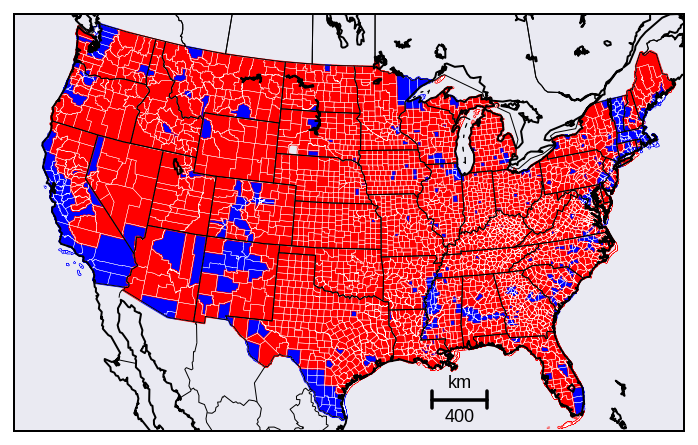

In [9]:
plot_map('16')

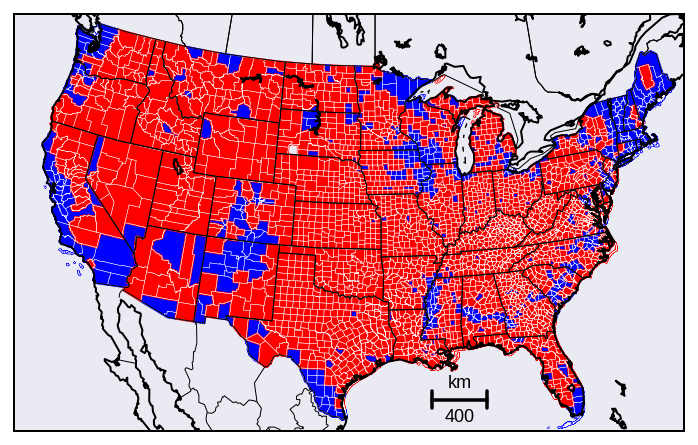

In [10]:
plot_map('12')

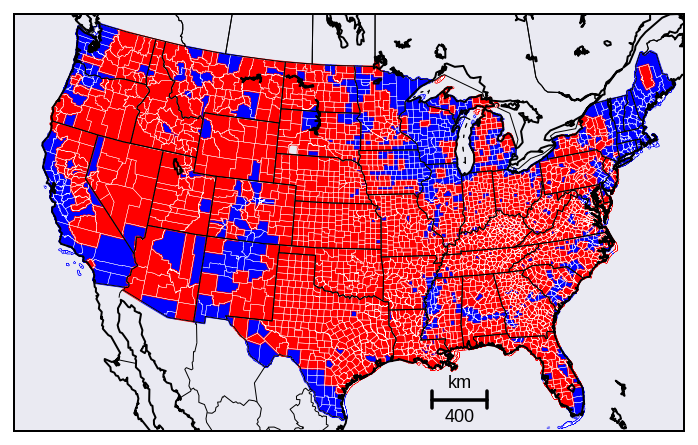

In [11]:
plot_map('08')

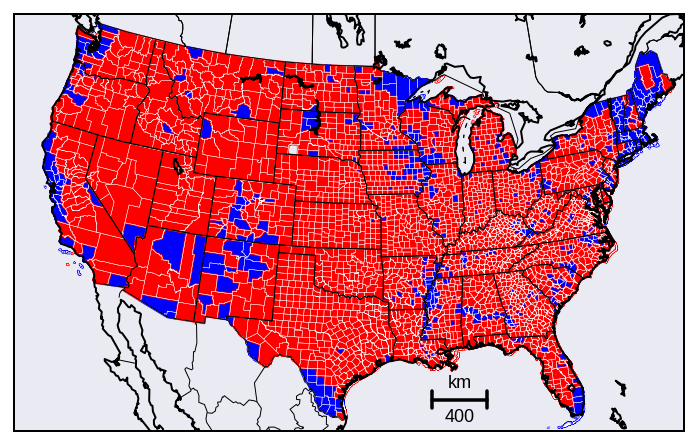

In [12]:
plot_map('04')

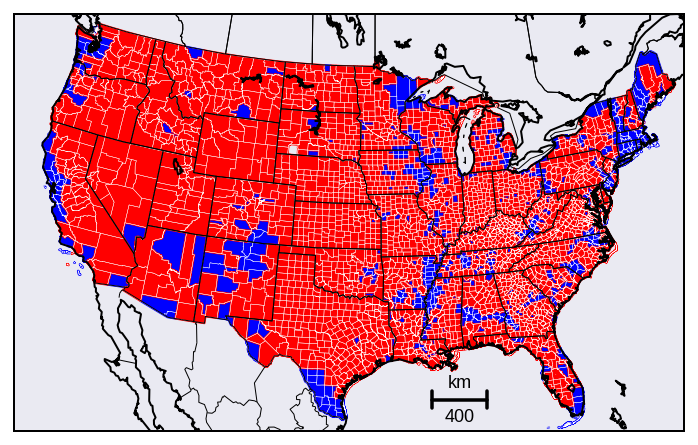

In [13]:
plot_map('00')